# Setup START
***
Skipped in slideshow mode, run manually before!

Ideally, the code would be placed with their corresponding content slides.\
Unfortunately, RISE slideshow mode will not execute SKIP slides and there is no other way to hide them.

In [ ]:
%pip install --upgrade pip
# OpenAI Gym related:
%pip install cmake
%pip install atari_py 
'''OpenAI devs actually messed up an indentation
    in the video recorder class in 0.18.x.
    If you want to see videos, wait for a patch or
    use 0.17.x.
'''
%pip install gym[box2d]==0.17.3
%pip install pyvirtualdisplay
%pip install tqdm

# Gridworld related:
%pip install pymdptoolbox

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [2]:
from IPython import display
import numpy as np
import base64
import io
import gym
from tqdm import tqdm
from gym.wrappers import Monitor

if IN_COLAB:
    from pyvirtualdisplay import Display
    d = Display()
    d.start()

'''
Below is a solution to record and display videos for
OpenAI Gym environments.
Why the hassle?
    It works both in Jupyter Notebook and Google Colab!
(The author would like to note how painful it has been
developing this)
'''    

def display_video_from_monitor(monitor):
    '''
    Converts all videos in a monitor to HTML videos
    '''
    if len(monitor.videos) == 0:
        print("No videos to render!")
        return
    for f in monitor.videos:
        video = io.open(f[0], 'r+b').read()
        encoded = base64.b64encode(video)

        display.display(display.HTML(data="""
            <video alt="test" controls>
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>
            """.format(encoded.decode('ascii'))))
    return

def make_video(env, model, max_steps=None):
    mon = Monitor(env, "/data/videos/", force=True)
    state = mon.reset()
    i = 0
    while True:
        action = model(state)
        state, r, d, _ = mon.step(action)
        if d: break
        i+=1
        if max_steps is not None and i>=max_steps: break
    if mon.stats_recorder.done == False:    
        mon.stats_recorder.save_complete()
        mon.stats_recorder.done = True
    mon.reset()
    display_video_from_monitor(mon)
    return mon

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from mdptoolbox import mdp

class Gridworld():
    def __init__(self, actions, w=4, h=3, rho=1.0, step_reward=0.0, cell_rewards={},
               terminal_states=[], blocked_cells=[]):
        self.actions = actions
        self.w, self.h = w, h
        self.rho = rho
        self.step_reward = step_reward
        self.cell_rewards = cell_rewards
        self.terminal_states = {tuple(x) for x in terminal_states}
        self.blocked_cells = {tuple(x) for x in blocked_cells}

        self.grid = np.zeros((h,w))
        self.states = np.array([[i,j] for i in range(h) for j in range(w)])
        self.num_states = w*h
        self.num_actions = len(actions)
        self.p = np.zeros((self.num_actions, self.num_states, self.num_states), "float32")
        self.r = np.zeros((self.num_actions, self.num_states, self.num_states), "float32")
        self._fill_p()
        self._fill_r()

    def _fill_p(self):
        # computing transition matrix:
        for a in range(self.num_actions):
            for i in range(self.num_states):
                # simulate performing action a_ in state i
                # action a is performed with prob. rho,
                # with prob. 1-rho, any other action is chosen,
                # which results in prob. (1-rho)/(num_moves-1) for
                # a specific action a_ != a
                for a_ in range(self.num_actions):
                    rh, rw = self.simulate_move(self.actions[a_], self.states[i])
                    j_ = rh*self.w + rw
                    prob = self.rho if a == a_ else (1-self.rho)/(self.num_actions-1)
                    self.p[a, i, j_] += prob
                # due to numerical inaccuracies, we need to ensure that each row
                # adds up to exactly 1, not 0.999995, because the solvers
                # really dont seem to like that
                row_sum = self.p[a,i].sum()
                if row_sum != 1:
                    if not np.allclose(row_sum,1, rtol=1e-5, atol=1e-5):
                        raise ValueError(f"Probability error at action{a}, state {i}"
                                         f" with prob. {row_sum}")
                    self.p[a,i] /= row_sum
        return
        # make sure we can't ever leave terminal states
        for (i,j) in self.terminal_states:
            # transition probability from state (i,j) to any other state 
            # must be zero, but one for (i,j)
            index = i*self.w+j
            self.p[:,index,:] = 0
            self.p[:, index, index] = 1

    def _fill_r(self):
        # transitions always give step_reward
        self.r.fill(self.step_reward)
        
        # ending on a rewarded cell gives the corresponding reward
        for (i,j), reward in self.cell_rewards.items():
            self.r[:,:, i*self.w+j] += reward

        # terminal cells do not give ANY reward after having reached them
        for (i,j) in self.terminal_states:
            k = i*self.w+j
            self.r[:, k, :] = 0

        # should staying on cells still give the associated rewards? No!
        for i in range(self.num_actions):
            np.fill_diagonal(self.r[i],0)

    def simulate_move(self, move, state):
        if self._is_blocked(state): return state
        if self._is_terminal(state): 
            return state
        nm = np.clip(np.array(move)+np.array(state), 0, (self.h-1, self.w-1))
        if self._is_blocked(nm):
            return state
        return nm

    def solve(self, discount=0.99, verbose=False):
        '''
        Solves the underlying MDP using Policy Iteration
        Returns an object with the optimal policy. See
        `mdp.PolicyIteration` doc for details.
        '''
        vi = mdp.PolicyIteration(self.p, self.r, discount)
        if verbose:
            vi.setVerbose()
        vi.run()
        return vi
    
    def _is_blocked(self, cy, cx=None):
        # cx: position along grid width
        if cx is None:
            cy, cx = cy
        return (cy, cx) in self.blocked_cells

    def _is_terminal(self, cy, cx=None):
        if cx is None:
            cy, cx = cy
        return (cy, cx) in self.terminal_states
    
    def _plot_policy(self, policy):
        a_l = 0.6 # arrow length
        for (i,j), a in list(zip(self.states, policy)):
            if self._is_terminal(i,j) or self._is_blocked(i,j): continue
           
            dh, dw = self.actions[a]
            if dh == -1:
                y_off = 1 - (1-a_l)/2.
                x_off = 0.5
            elif dh == 0:
                y_off = 0.5
                if dw == -1:
                    x_off = 1 - (1-a_l)/2.0
                elif dw == 1:
                    x_off = (1-a_l)/2.0
                else: raise ValueError("Invalid action to plot!")
            elif dh == 1:
                y_off = (1-a_l)/2.0
                x_off = 0.5
            else: raise ValueError("Invalid action to plot")
            plt.arrow(j+x_off, i+y_off, dw*a_l, dh*a_l, width=0.1, 
                      head_width=0.4, head_length=0.6*0.35, fc="k", ec="k",
                      length_includes_head=True, linewidth=0, overhang=0.3, 
                      zorder=10)
        return

    def _plot_terminal_states(self):
        for (i,j) in self.terminal_states:
            c = plt.Circle((j+0.5,i+0.5), radius=0.3, fill=False, ec="black",
                          lw=3, zorder=6)
            plt.gca().add_patch(c)

    def _plot_blocked_cells(self):
        for (i,j) in self.blocked_cells:
            rect = patches.Rectangle((j,i),1,1, zorder=1, color=(1,219/255,147/255))
            plt.gca().add_patch(rect)        
            
    def _plot_rewards(self, resize_factor):
        if len(self.cell_rewards) == 0: return

        neg_cm = plt.get_cmap("Reds")
        pos_cm = plt.get_cmap("Greens")
        rmax = max(abs(x) for x in self.cell_rewards.values())
        rmin = -rmax
        for (i,j), r in self.cell_rewards.items():
            plt.text(j+0.05,i+0.95, f"{r:.1f}", zorder=10, weight="bold",
                    size=8*resize_factor)
            # to get the right color, we normalize to 0,255
            r_norm = 1.0 * (r-rmin)/(rmax-rmin)
            cm = pos_cm
            if r < 0:
                r_norm = 1.0 - r_norm
                cm = neg_cm
            col = cm(r_norm)
            rect = patches.Rectangle((j,i),1,1, zorder=1, color=col)
            plt.gca().add_patch(rect)   
            
    def plot(self, policy=None, height=None, width=None):
        if height is None and width is None:
            height = self.h
            width = self.w
        if height is None:
            height = self.h*(width/self.w)
        if width is None:
            width = self.w*(height/self.h)
        rf = height/self.h
        fig, ax = plt.subplots(figsize=(width, height))
        if policy is not None:
            self._plot_policy(policy)
        self._plot_terminal_states()
        self._plot_blocked_cells()
        self._plot_rewards(rf)
        ax.grid(zorder=10, lw=1)
        

        plt.xlim(0, self.w)
        plt.ylim(0, self.h)
        plt.tick_params(axis='both', which='both', bottom=False, top=False, 
                        labelbottom=False, right=False, left=False, labelleft=False)
        plt.xticks(range(self.w))
        plt.yticks(range(self.h))
        ax.invert_yaxis()
        plt.title("Grid world")
        plt.show()

In [4]:
import numpy as np
from tensorflow.keras.layers import (
    Dense, Input, Dropout    
)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow import keras
from tqdm import tqdm
import matplotlib.pyplot as plt

import gym

import pandas as pd

def mov_avg(x, l):
    return pd.Series(x).rolling(l).mean().iloc[l-1:].values

def episode(env, model, max_steps=None):
    '''
    Runs a single episode of the model in env for at most max_steps
    Returns states, rewards, action_probabilities and the
    estimated rewards by the critic.
    '''
    states = []
    action_probs = []
    est_rewards = []
    rewards = []

    state = env.reset()
    i = 0
    max_steps = np.inf if max_steps is None else max_steps
    while i < max_steps:
        state = tf.convert_to_tensor(state)
        state = tf.expand_dims(state, 0)
        states.append(state)
        a_p, e_w = model(state)

        action = np.random.choice(env.action_space.n, p=np.squeeze(a_p))
        state, reward, done, info = env.step(action)

        action_probs.append(a_p[0, action])
        est_rewards.append(e_w[0,0])
        rewards.append(reward)

        i += 1
        if done:
            break
    env.close()
    return states, rewards, action_probs, est_rewards

def sample_action(model, state):
    '''
    Given a model and a state, samples an action from model
    '''
    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)
    a_p, e_w = model(state)
    action = np.random.choice(env.action_space.n, p=np.squeeze(a_p))
    return action

class ActorCriticDiscrete():
    '''
    Implements the Actor Critic network structure for discrete action spaces
    '''
    def __init__(self, env, model, critic_loss=keras.losses.Huber(),
                opt="Adam", val_env=None):
        self.env = env
        self.val_env = env if val_env is None else val_env
        self.model = model
        self.critic_loss = critic_loss
        self.opt = opt

    def train_episode(self, discount, max_train_steps):
        with tf.GradientTape() as tape:
            states, rewards, action_probs, est_rewards = episode(self.env, self.model, max_train_steps)
            reward = sum(rewards)

            returns = []
            discounted_sum = 0
            for r in rewards[::-1]:
                discounted_sum = r + discount * discounted_sum
                returns.insert(0, discounted_sum)
            returns = np.array(returns)
            returns = (returns - returns.mean()) / (returns.std()+0.000001)

            returns = tf.convert_to_tensor(returns, "float32")

            critic_loss = self.critic_loss(est_rewards, returns)
            al = -tf.math.log(action_probs) * (returns - est_rewards)
            actor_loss = tf.reduce_mean(al)
            loss = actor_loss + critic_loss

            gradients = tape.gradient(loss, self.model.trainable_weights)
            self.opt.apply_gradients(zip(gradients, self.model.trainable_weights))
        return reward

    def val_episode(self, val_episodes=1, max_val_steps=None):
        val_rewards = []
        for val_e in range(val_episodes):
            s, r, ap, er = episode(self.val_env, self.model, max_val_steps)
            val_rewards.append(sum(r))
        val_rewards = np.array(val_rewards)
        return val_rewards

    def sample_action(self, state):
        '''
        Convenienve wrapper to quickly run a state through model.
        Returns an action
        '''
        return sample_action(self.model, state)

    def plot_reward_history(self, history, avg_length=5):
        plt.figure(figsize=(14,5))
        plt.plot(history, alpha=0.7, label="Rewards")
        plt.plot(np.arange(len(history))[avg_length-1:], mov_avg(history, avg_length), 
                 alpha=0.7, label="Smoothed rewards")
        plt.xlabel("Episodes")
        plt.ylabel("Reward")
        plt.title(self.env.spec.id)
        plt.legend()
        plt.show()

    def train(self, epochs, discount, max_train_steps = None, validate_every=5, 
              val_episodes=5, max_val_steps = 200, video=True, max_video_steps=500,
             avg_reward_goal=None):

        reward_history = []
        try:
            for epoch in tqdm(range(epochs)):

                reward = self.train_episode(discount, max_train_steps)
                reward_history.append(reward)
                if epoch % validate_every == 0:
                    if video:
                        make_video(self.val_env, self.sample_action, max_video_steps)
                    if val_episodes > 0:
                        vr = self.val_episode(val_episodes, max_val_steps)
                        print(f"Epoch {epoch}/{epochs}: Validation reward mean/min/max: "
                              f"{vr.mean():0.3f}, {vr.min():0.3f}, {vr.max():0.3f}")
                        if avg_reward_goal is not None and vr.mean() >= avg_reward_goal:
                            print(f"Reached goal of mean reward {avg_reward_goal}, stopping!")
                            break
        except KeyboardInterrupt:
            pass
        reward_history = np.array(reward_history)
        return reward_history


# Setup END
***
(Click this cell, and do "Run all above")

# An introduction to Reinforcement Learning
***
Based on:
* **MIT 6.S091**: Introduction to Deep Reinforcement Learning, by Lex Fridman
* **UC Berkeley CS 287**: Advanced Robotics, by Pieter Abbeel

In [63]:
try:
    IN_COLAB
    print("Setup was run :)")
except:
    print("Don't forget to run the setup!")

Setup was run :)


# Agenda
***
* Organisational
* Short recap of last challenge
* Lecture 2: RL & Deep RL
* Challenge 2: Landing on the moon

# Organisational
***
The upcoming lectures have been swapped. We will have:
* **21.05**: Lecture on NLP and Language Models
* **04.06**: Machine Learning in Biomedicine, Prof. Kacprowski guest lecture

# Minimal MNIST Recap
***
Best solution: 129 parameters @ 90.6% accuracy
* Tons of trial and error, grid search for hyperparameters

# Deep Reinforcement Learning
***

# What is Deep Reinforcement Learning?
***
Last lecture we heard about **Deep Learning**:
* Learn from examples, supervised
* Find patterns, representations

**Reinforcement Learning** is about:
* Solving sequential decision making problems
    * Comprehend the world and *act* based on that
* How? Through trial and error in a world that provides rewards

**Deep RL** is RL + Neural networks

# Types of learning
***
* Supervised, Semi-supervised
* Unsupervised
* Reinforcement learning

In each case of machine learning, the loss function **supervises** the learning
* Someone has to say what's good and what's bad!

It's more about the amount of human effort involved in training.
* Supervised learning: Teach by example
    * Learning patterns from data
* Reinforcement learning: Teach by experience
    * Learning from a world by exploration

# Reinforcement learning in humans
***
Humans appear to learn from very few examples of trial and error.
* How, is still an open question

There are several possible answers to why humans might learn so fast
* Data & Hardware: 230 million years of trial and error
* Imitation learning: Observation of other humans
* Algorithms: Better than backpropagation and gradient descent

# Reinforcement learning framework
***
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/da/Markov_diagram_v2.svg/640px-Markov_diagram_v2.svg.png" style="float: right;">

At each step, the **agent**:
* Executes an **action**
* Observes a new **state**
* Receives a **reward**

Different flavors:
* Fully Observable (Chess) vs Partially Observable (Poker)
* Single Agent (Atari) vs Multi Agent (Deep Traffic)
* Deterministic (CartPole) vs Stochastic (Deep Traffic)
* Static (Chess) vs Dynamic (Deep Traffic)
* Discrete (Chess) vs Continuous (CartPole)

# The challenge for real world RL applications
***
The world an agent might learn from is a model designed by us
* Agents live in a (partial) simulation of our world

To apply RL agents to the real world, they need to *transfer* their experience
* Two options:
    * Improve the simulations
    * Improve algorithms to better generalize from simulation to real world

# Components of an RL agent
***
**Policy $\pi$**, an agent's behavior function:\
$\pi(s,a)=P\left(a_t=a\mid s_t=s\right)$

**Value function $Q$**: How good is each state and/or action\
$\displaystyle Q^\pi(s,a)=E\left[R\mid s,a,\pi\right]$

**Reward $R_a(s,s')$**:\
The immediate reward after transition from $s$ to $s'$ with action $a$

**Model**: The agent's representation of the environment
<br>
<br>
<center>$s_0,a_0,r_1,s_1,a_1,r_2,\dots,s_{n-1},a_{n-1},r_n$</center>


# Meaning of life: Maximize Reward
***
The purpose of an RL agent is to maximize the future reward\
$R_t=r_t+r_{t+1}+\cdots+r_n$

Rewards are discounted by factor $\gamma$:\
$R_t=r_t+\gamma r_{t+1}+\gamma^2 r_{t+2}+\cdots+\gamma^{n-t}r_n$

Why discounted?
* Math trick to prove certain convergence properties
* Also accounts for increasing uncertainty of far out rewards

A good strategy would be to always choose the action that gives the highest future reward

# Grid World or *Robot in a room*
***
Imagine a robot in a room. It may move and find:
* Positive and negative rewards, as shown by value and color
* Terminal states, indicated by a circle
* Walls/Blocks, appearing yellow(ish)

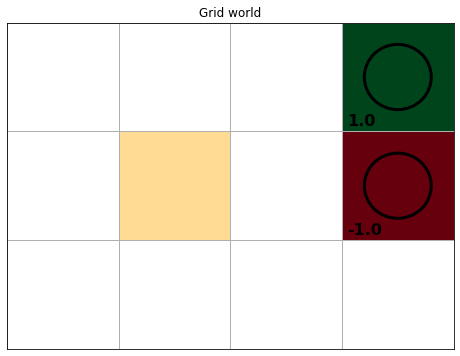

In [7]:
rewards = {(0,3):1,(1,3):-1}
terminal_states = rewards.keys()
blocks = [(1,1)]
grid_world = Gridworld([],w=4,h=3, cell_rewards=rewards, 
                       terminal_states=terminal_states,
                       blocked_cells=blocks)
grid_world.plot(width=8)

# Deterministic movement
***
We'll allow our robot to move UP, DOWN, LEFT and RIGHT, but each move costs
* Denoted by `step_reward=-0.04`

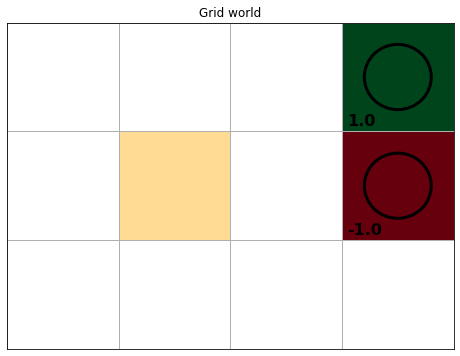

In [81]:
actions = np.array([
    [-1,0], # UP
    [1,0], # DOWN 
    [0,-1], # Left
    [0,1], # Right
])

rewards = {(0,3):1,
           (1,3):-1}
terminal_states = list(rewards.keys())
blocks = [(1,1)]

grid_world = Gridworld(actions,w=4,h=3, step_reward=-0.04,
                       cell_rewards=rewards, 
                       terminal_states=terminal_states,
                       blocked_cells=blocks)

grid_world.plot(width=8)

# Markov decision process (MDP)
***
What would be the optimal move on each cell to achieve the highest possible reward?
* The theory behind Markov decision processes allows us to solve this!
    * This is where the discount factor $\gamma$ is needed

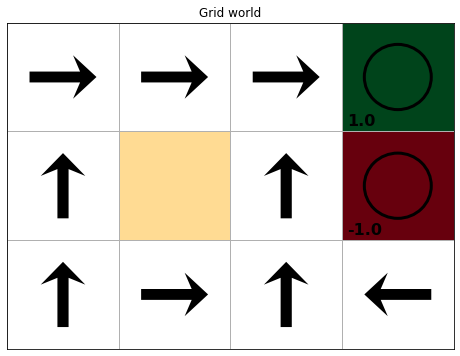

In [66]:
result = grid_world.solve(discount=0.99)
grid_world.plot(policy=result.policy, width=8)

**Policy**: Shortest path to $+1$ reward

# Optimal policy for positive `step_reward`
***
Everything else being equal, how would a positive `step_reward` influence the agent's optimal behavior?

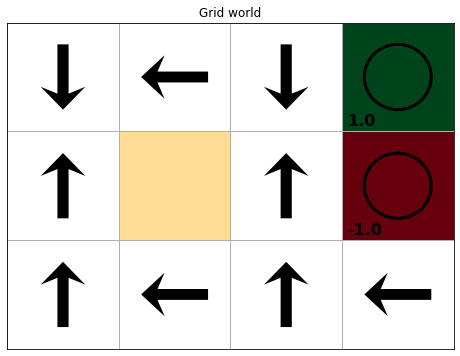

In [67]:
grid_world = Gridworld(actions,w=4,h=3, step_reward=0.04,
                       cell_rewards=rewards, 
                       terminal_states=terminal_states,
                       blocked_cells=blocks)
result = grid_world.solve(discount=0.99)
grid_world.plot(policy=result.policy, width=8)

**Policy**: Never terminate!

# Adding uncertainty
***
So far, each action chosen by the agent resulted in exactly the anticipated outcome
* It's a *deterministic* world our robot lives in

However, some systems are stochastic by nature, or too complex to model deterministically
* How would uncertainty impact the optimal policy in our grid world?
* We let $\rho\in (0,1]$ denote the probability of executing the intended action $a$
    * But with prob. $1-\rho$ any other action is executed

Here is the deterministic result ($\rho=1$):

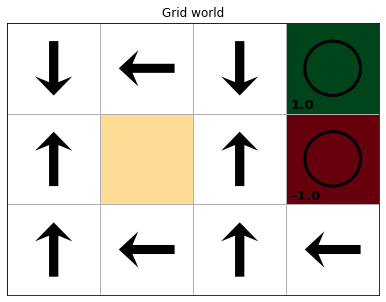

In [68]:
grid_world = Gridworld(actions,w=4,h=3, step_reward=0.04,
                       cell_rewards=rewards, 
                       terminal_states=terminal_states,
                       blocked_cells=blocks)
result = grid_world.solve(discount=0.99)
grid_world.plot(policy=result.policy, height=5)

What happens for $\rho=0.7$ ?

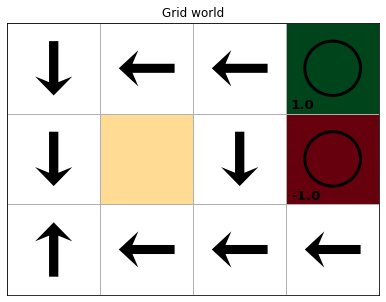

In [69]:
grid_world = Gridworld(actions,w=4,h=3, step_reward=0.04,
                       rho=0.7, cell_rewards=rewards, 
                       terminal_states=terminal_states,
                       blocked_cells=blocks)
result = grid_world.solve(discount=0.99)
grid_world.plot(policy=result.policy, height=5)

# Lessons learned from Grid World
***
1. Environment model has big impact on optimal policy
2. Reward structure has big impact on optimal policy

In [70]:
import IPython
IPython.display.HTML('''
<iframe width="800" height="510" src="https://www.youtube.com/embed/tlOIHko8ySg" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
''')

# 3 Types of Reinforcement learning
***
**Model-based**
* Learn the model of the world, then plan on it
* Update model and re-plan often

**Value-based**
* Learn the values of states or state-action pairs
* Act by choosing best action in state
* Exploration is a needed add-on

**Policy-based**
* Learn the stochastic behavior function $\pi$
* Act by sampling the policy
* Exploration comes from the stochastic nature of the policy function

# Sample efficiency
***
<center><img src="img/slides/rl_sample_efficiency.png"/></center>

**Off-policy** are value-based agents
* Constantly update the quality of being in a certain state
* Always take the best next state
    * Except sometimes, in order to explore other states

**On-policy** are policy-based agents

**Training RL agents can be a very lengthy process**
* Training usually comes with high variance

# Actor-Critic
***
The **Actor** component takes the state of the world and returns a probability distribution over the actions
* Ideally, the best actions get high probability
* A policy-based idea

We want the **Critic** to take a state and return the estimated future rewards
* Estimates how good the choices of the actor are
* A value-based approach

They are trained together to get better at their respective tasks:
* Critic gets more accurate value estimations
* Actor assigns higher probability to high-valued actions

# Actor-Critic network structure
***
<center>
<img src="https://www.mdpi.com/sensors/sensors-19-01547/article_deploy/html/images/sensors-19-01547-g002.png" style="width:70%;"/>
</center>

# Actor-Critic training outline
***
1. Run an episode
    * Record state, action and reward for each step
2. Compute discounted rewards
    * Actions towards the end of the episode are usually more important
3. Derive labels for the actor
    * For each action with high reward, we want the actor to output high probability
        * Low rewards should decrease probability of choosing that action
4. Critic labels are simply to predict exactly the rewards of the current episode
    * Regression task
5. Repeat.

# Variance in training
***
Most systems with competing network components suffer from high variance (GANs, VAs, RL)
<center>
<img src="img/slides/ll_rewards_single.png"/>
<img src="img/slides/ll_rewards_multiple.png" />
</center>

# Environments: Meet OpenAI Gym
***
The `gym` package from OpenAI is a repository of multiple RL environments:
* Classic control, i.e. balancing a pole on a cart
* Robotics: Learning to pick up or stack in a 3D world
* MuJoCo: Learning movement in a physics simulator (license required)
* Atari: Huge amount of Atari 2600 games, like Breakout, SpaceInvaders or Pong
* Tons of third party environments

Difficulty ranges from easy to still not solved!

# Starting simple: CartPole-v0
***
Reward: +1 for each step where the pole is upright

In [75]:
env = gym.make('CartPole-v0')
# random action model:
model = lambda state: env.action_space.sample()

make_video(env, model, max_steps=200)
env.close()

# Intermediate: LunarLander-v2
***
Rewards: Landing, Crashing, Fuel

In [72]:
env = gym.make('LunarLander-v2')
# random action model:
model = lambda state: env.action_space.sample()

make_video(env, model, max_steps=200)
env.close()

# Impossible: MontezumaRevenge-v0
***
Please apply to OpenAI, if you solve this:\
(and include me in your paper..)

In [ ]:
env = gym.make('MontezumaRevenge-ram-v0')
# random action model:
model = lambda state: env.action_space.sample()

make_video(env, model, max_steps=500)
env.close()

# Actor-critic: Code
***
Training procedure already in class `ActorCriticDiscrete`.\
You just need to provide:
* An environment
* The actual network structure
* Optional: Optimizer, loss function for the critic regression task

In [76]:
env = gym.make('CartPole-v0')
val_env = env.unwrapped
env.seed(1); val_env.seed(1)
with tf.device("/cpu:0"):
    tf.random.set_seed(1)

    input_layer = Input(env.observation_space.shape)
    l = Dense(128, "relu")(input_layer)
    actor = Dense(env.action_space.n, "softmax", name="actor")(l)
    critic = Dense(1, name="critic")(l)
    model = Model(input_layer, [actor, critic])

    model.summary(50)
    opt = keras.optimizers.Adam(lr=0.02)
    critic_loss = keras.losses.Huber()

    ac = ActorCriticDiscrete(env, model, critic_loss, opt, 
                              val_env=val_env)

Model: "functional_29"
__________________________________________________
Layer (type)    Output Sha Param Connected to     
input_15 (Input [(None, 4) 0                      
__________________________________________________
dense_14 (Dense (None, 128 640   input_15[0][0]   
__________________________________________________
actor (Dense)   (None, 2)  258   dense_14[0][0]   
__________________________________________________
critic (Dense)  (None, 1)  129   dense_14[0][0]   
Total params: 1,027
Trainable params: 1,027
Non-trainable params: 0
__________________________________________________


  0%|                                                 | 0/2000 [00:00<?, ?it/s]

  0%|                                         | 3/2000 [00:01<13:56,  2.39it/s]

Epoch 0/2000: Validation reward mean/min/max: 38.000, 18.000, 86.000


  2%|█                                       | 50/2000 [00:11<07:05,  4.58it/s]

  3%|█                                       | 51/2000 [00:15<46:10,  1.42s/it]

Epoch 50/2000: Validation reward mean/min/max: 108.700, 43.000, 139.000


  5%|█▉                                     | 100/2000 [00:33<12:13,  2.59it/s]

  5%|█▊                                   | 101/2000 [00:39<1:03:27,  2.01s/it]

Epoch 100/2000: Validation reward mean/min/max: 145.600, 56.000, 200.000


  8%|██▉                                    | 150/2000 [00:50<04:46,  6.45it/s]

  8%|██▉                                    | 152/2000 [00:53<23:44,  1.30it/s]

Epoch 150/2000: Validation reward mean/min/max: 74.500, 58.000, 96.000


 10%|███▉                                   | 200/2000 [01:06<08:56,  3.36it/s]

 10%|███▉                                   | 201/2000 [01:11<44:07,  1.47s/it]

Epoch 200/2000: Validation reward mean/min/max: 119.200, 74.000, 200.000


 12%|████▉                                  | 250/2000 [01:24<08:03,  3.62it/s]

 13%|████▉                                  | 251/2000 [01:29<53:38,  1.84s/it]

Epoch 250/2000: Validation reward mean/min/max: 146.800, 118.000, 197.000


 15%|█████▊                                 | 300/2000 [01:44<09:47,  2.89it/s]

 15%|█████▌                               | 301/2000 [01:52<1:16:48,  2.71s/it]

Epoch 300/2000: Validation reward mean/min/max: 147.700, 119.000, 200.000


 18%|██████▊                                | 350/2000 [02:07<10:57,  2.51it/s]

 18%|██████▊                                | 350/2000 [02:16<10:41,  2.57it/s]

Epoch 350/2000: Validation reward mean/min/max: 196.200, 173.000, 200.000
Reached goal of mean reward 195, stopping!


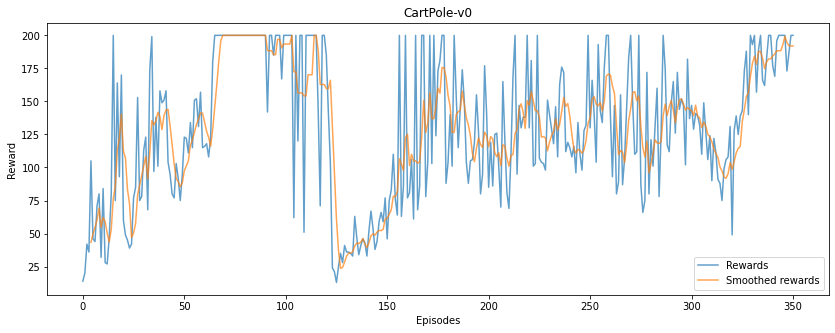

In [77]:
with tf.device("/cpu:0"):
    tf.random.set_seed(1)
    h = ac.train(epochs=2000, discount=0.99, 
                  max_train_steps=200, validate_every=50, 
                  val_episodes=10, max_val_steps=200, 
                  video=True, max_video_steps=500, 
                  avg_reward_goal=195)
ac.plot_reward_history(h)

# Shooting for the stars
***
Can our model learn to land on the moon?

In [8]:
env = gym.make('LunarLander-v2')
val_env = env.unwrapped

with tf.device("/cpu:0"):
    tf.random.set_seed(1)

    input_layer = Input(env.observation_space.shape)
    l = Dense(128, "relu")(input_layer)
    actor = Dense(env.action_space.n, "softmax", name="actor")(l)
    critic = Dense(1, name="critic")(l)
    model = Model(input_layer, [actor, critic])

    model.summary(50)
    opt = keras.optimizers.Adam(lr=0.02)
    critic_loss = keras.losses.MeanSquaredError()

    ll = ActorCriticDiscrete(env, model, critic_loss, opt, 
                              val_env=val_env)

Model: "functional_3"
__________________________________________________
Layer (type)    Output Sha Param Connected to     
input_2 (InputL [(None, 8) 0                      
__________________________________________________
dense_1 (Dense) (None, 128 1152  input_2[0][0]    
__________________________________________________
actor (Dense)   (None, 4)  516   dense_1[0][0]    
__________________________________________________
critic (Dense)  (None, 1)  129   dense_1[0][0]    
Total params: 1,797
Trainable params: 1,797
Non-trainable params: 0
__________________________________________________


  0%|                                                  | 0/151 [00:00<?, ?it/s]

  1%|▎                                         | 1/151 [00:12<31:09, 12.46s/it]

Epoch 0/151: Validation reward mean/min/max: 110.373, 103.493, 120.072


 19%|███████▌                                 | 28/151 [00:23<01:44,  1.17it/s]


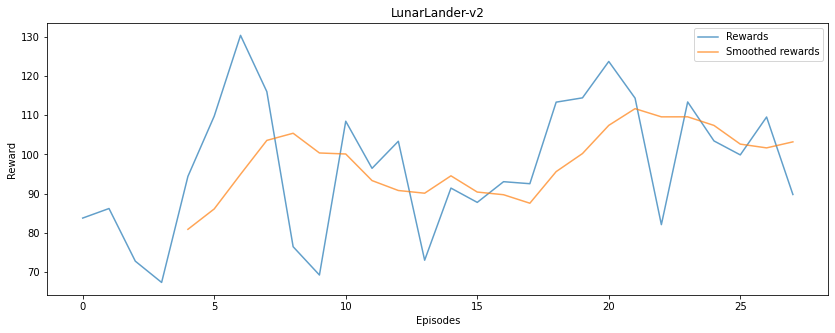

In [23]:
with tf.device("/cpu:0"):
    ll_hist = ll.train(epochs=151, discount=0.99, 
                  max_train_steps=200, validate_every=50, 
                  val_episodes=5, max_val_steps=200, 
                  video=True, max_video_steps=500, 
                  avg_reward_goal=None)
    ll.plot_reward_history(ll_hist)

# Comparison
***
<center><div style="display:flex; justify-content: space-evenly;">
    <div style="flex-basis:40%">
        <center>Episode 50</center>
        <video width="95%" controls src="img/slides/ll_ep50.mp4" type="video/mp4" />
    </div>
    <div style="flex-basis:40%">
        <center>Episode 1500</center>
        <video width="95%" controls src="img/slides/ll_ep1500.mp4" type="video/mp4" />
    </div>
</div>
</center>
<center><img src="img/slides/ll_rewards_2k.png"/></center>